<a href="https://colab.research.google.com/github/dvarelaj/nlp-miniproyecto-icesi/blob/main/Sesion%201/Actividad%20%237/analisis_sentimientos_quejas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. ANÁLISIS DE SENTIMIENTO EN QUEJAS DE SOPORTE TÉCNICO (ARL)
**Autores:** Diana Varela, Daniel García, Farid Sandoval  
**Programa:** Maestría en Inteligencia Artificial Aplicada - Universidad ICESI  


# Mini-Proyecto: Análisis de Sentimientos con NLP
## Corpus: Quejas y Reclamos ARL (Muestra Anonimizada)

---

### Contexto del proyecto
Este proyecto aplica técnicas de **Procesamiento de Lenguaje Natural (NLP)** y **Sentiment Analysis** sobre un corpus real de 101 quejas recibidas por una Administradora de Riesgos Laborales (ARL) colombiana.

En esta actividad, se busca replicar el flujo de trabajo del notebook de reseñas de películas, pero aplicado a un dominio específico y complejo: **quejas técnicas de una ARL en español**.

El dataset ha sido **anonimizado previamente** para proteger la privacidad de los usuarios, sustituyendo nombres y documentos por la etiqueta `[ID_ANONIMIZADO]`. El objetivo principal es evaluar el desempeño de un modelo de lenguaje en la clasificación de polaridad (negativo, neutral, positivo) en un entorno de servicio al cliente.

A diferencia del ejemplo base, aquí enfrentamos dos retos adicionales:
* **Cambio de Idioma:** Se migra de VADER (inglés) a `pysentimiento`, un modelo basado en Deep Learning (BERT) optimizado para español.
* **Dominio Técnico:** El lenguaje corporativo y técnico presenta matices de neutralidad y negatividad que difieren del lenguaje coloquial de las películas.

---

## ¿Qué técnicas aplicamos en este Notebook?
A lo largo de este notebook, realizaremos el ciclo completo de evaluación de un modelo de IA:

| Paso | Técnica | Objetivo |
|:---|:---|:---|
| **1** | **Configuración** | Preparar el entorno con `pysentimiento` y `sklearn`. |
| **2** | **Carga del Dataset** | Ingesta de la muestra anonimizada de 101 quejas. |
| **3** | **Inferencia del Modelo** | Predicción automatizada de sentimientos usando IA. |
| **4** | **Comparación (Ground Truth)** | Contrastar predicciones contra el etiquetado manual. |
| **5** | **Métricas de Desempeño** | Calcular Accuracy, Precision y F1-Score. |
| **6** | **Matriz de Confusión** | Visualizar dónde el modelo acierta y dónde se confunde. |

---

### Herramientas utilizadas
- **pysentimiento**: Librería especializada en análisis de sentimientos para español.
- **Scikit-learn**: Para el cálculo de métricas de desempeño (Accuracy, F1-Score).
- **Pandas**: Para la estructuración y manipulación de la muestra.
- **Seaborn & Matplotlib**: Para la generación del mapa de calor de la matriz de confusión.

# Paso 1 — Importación de librerías y configuración del entorno
En esta etapa inicial preparamos el entorno técnico para el análisis de sentimientos. A diferencia del procesamiento clásico, aquí integramos:

**pysentimiento:** Para utilizar modelos preentrenados (Transformers) especializados en la detección de polaridad en español.

**pandas:** Para la manipulación del dataset de quejas y la estructuración de los resultados.

**scikit-learn (sklearn):** Para el cálculo de métricas de calidad como la matriz de confusión y el reporte de accuracy.

**matplotlib y seaborn:** Para generar las visualizaciones estadísticas que permiten interpretar el desempeño del modelo.

In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.matcher import Matcher
from collections import Counter
import spacy.cli
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Paso 2 — Carga y exploración del dataset

Procedemos a importar el archivo CSV que contiene las quejas directamente desde un repositorio público en GitHub usando pandas. Es fundamental que el dataset incluya la columna de texto original (descripcion_anonimizado) y, para este ejercicio de validación, la columna con el sentimiento real que (y_true) que fue etiquetada manualmente.

In [2]:
# URL de GitHub (raw content)
url_datos = 'https://raw.githubusercontent.com/dvarelaj/nlp-miniproyecto-icesi/main/Sesion%201/Data%20Base/Quejas_Anonimizadas_Muestra_Etiqueta.csv'
df = pd.read_csv(url_datos, delimiter=';')

# Paso 3 - Pre-Procesamiento
Para garantizar la calidad de las predicciones, realizamos un flujo de limpieza.

* **Carga de datos:** Se utiliza una muestra de **101 registros** anonimizados de la ARL.
* **Limpieza:** Se eliminan valores nulos y celdas con espacios en blanco en la descripción de la queja para evitar errores en el tokenizador.

In [3]:
# Limpieza básica
df.dropna(subset=['descripcion_anonimizada'], inplace=True)
df = df[df['descripcion_anonimizada'].str.strip() != '']

print(f"Total de quejas para analizar: {len(df)}")

Total de quejas para analizar: 101


# Paso 4 - Implementación del Modelo

En este paso, recorremos cada una de las quejas y se las entregamos al modelo. El modelo analizará el contexto semántico de cada frase y nos devolverá una etiqueta: `POS` (Positivo), `NEU` (Neutral) o `NEG` (Negativo). Estos resultados se almacenarán en una nueva columna de nuestro DataFrame.

Utilizaremos **Sentiment Analyzer** basado en Transformers, ya que nuestro archivo de datos tiene quejas y peticiones en español.

Este modelo es superior para el español ya que:
1. Entiende el contexto bidireccional de las frases.
2. Detecta ironía y matices técnicos que modelos más simples ignorarían.

In [4]:
#!pip install pysentimiento

In [5]:
!pip install pysentimiento
import pysentimiento
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicamos el análisis a nuestras quejas
df['sentiment_results'] = df['descripcion_anonimizada'].apply(lambda x: analyzer.predict(x))
df['prediction'] = df['sentiment_results'].apply(lambda r: r.output)
df['compound_score'] = df['sentiment_results'].apply(lambda r: r.probas['NEG'] * -1 if r.output == 'NEG' else r.probas['POS'])

df[['descripcion_anonimizada', 'prediction']].head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

,descripcion_anonimizada,prediction
0,usuaria se comunica porque requiere ingresar a...,NEG
1,empresa cc : [ID_ANONIMIZADO] ingresa con usua...,NEG
2,se comunica porque esta ingresando al portal p...,NEU
3,nehcesito afiliar a unas personas pero me sale...,NEG
4,id chat : [ID_ANONIMIZADO] canal de atencion w...,NEG


## Paso 5 — Evaluación de resultados: Accuracy y Reporte de Clasificación

Para determinar si nuestro modelo es confiable, comparamos sus predicciones contra nuestro "estándar de oro" (el etiquetado manual).
* El **Accuracy** nos dirá el porcentaje total de aciertos.
* El **Reporte de Clasificación** nos mostrará el desempeño detallado por cada categoría de sentimiento.

In [6]:
# Conteo de los resultados obtenidos por el modelo
conteo_sentimientos = df['prediction'].value_counts()
print(conteo_sentimientos)

prediction
NEG    71
NEU    30
Name: count, dtype: int64


In [7]:
# Predicciones del modelo
y_pred = [p.lower() for p in df['prediction'].tolist()]

# Obtener las etiquetas verdaderas
y_true = df['y_true'].tolist()

# Generar el reporte (requires y_true)
reporte = classification_report(y_true, y_pred)
print("### Reporte de Clasificación ###")
print(reporte)

# Calcular exactitud total (requires y_true)
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy Total: {accuracy:.2f}")

### Reporte de Clasificación ###
              precision    recall  f1-score   support

         neg       0.86      0.76      0.81        80
         neu       0.37      0.52      0.43        21

    accuracy                           0.71       101
   macro avg       0.61      0.64      0.62       101
weighted avg       0.76      0.71      0.73       101

Accuracy Total: 0.71


## Paso 6 — Visualización: Matriz de Confusión

La matriz de confusión es la herramienta definitiva para entender el comportamiento de la IA. Nos permite ver, por ejemplo, cuántas quejas "Negativas" fueron clasificadas erróneamente como "Neutrales", ayudándonos a identificar sesgos o debilidades en el modelo.

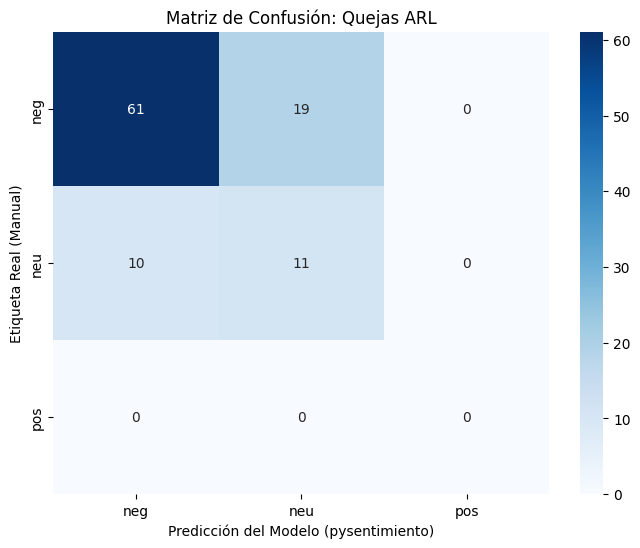

In [8]:
# Crear la matriz de confusión
labels = ['neg', 'neu', 'pos']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Graficar
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción del Modelo (pysentimiento)')
plt.ylabel('Etiqueta Real (Manual)')
plt.title('Matriz de Confusión: Quejas ARL')
plt.show()

# 4. ANÁLISIS DE RESULTADOS

Una vez ejecutado el modelo sobre las 101 quejas, se presentan los siguientes hallazgos críticos basados en las métricas obtenidas:

### A. RENDIMIENTO DEL MODELO
El modelo supera significativamente la línea base del 50%, logrando un **Accuracy del 71%**. Sin embargo, el rendimiento es asimétrico:
* **Alta Precisión en Negativos (0.86):** El modelo es muy efectivo detectando la molestia real del usuario en temas de fallas técnicas.
* **Debilidad en Neutrales (Precision 0.37):** Existe una confusión importante entre quejas informativas y consultas de trámites.



### B. OBSERVACIONES LINGÜÍSTICAS
Como hallazgo, identificamos un fenómeno de **"Ambigüedad de Dominio"**:
* Términos como *"mantenimiento"*, *"portal no carga"* o *"no permite ingresar"* son clasificados frecuentemente como **NEG** (negativos) por el modelo.
* Lingüísticamente, estas frases podrían ser informativas (Neutrales), pero en el ecosistema de una ARL, el modelo interpreta correctamente la carga emocional de frustración implícita en la imposibilidad de realizar una tarea.

### C. COMPARACIÓN CON EL MODELO BASE
* **Desbalance Natural:** A diferencia del dataset de películas (balanceado 50/50), las quejas de la ARL están **naturalmente desbalanceadas hacia lo negativo**.
* **Ausencia de Positivos:** La ausencia total de sentimientos positivos (**POS = 0**) refleja la realidad de los canales de soporte: el usuario rara vez se comunica para expresar satisfacción en un canal de reclamos.

/tmp/ipython-input-3801988812.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prediction', data=df, palette='viridis')


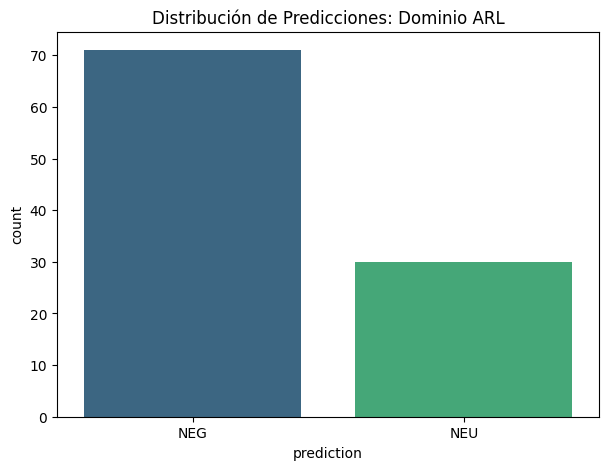

In [9]:
# Gráfico de barras para visualizar el desbalance de sentimientos
plt.figure(figsize=(7,5))
sns.countplot(x='prediction', data=df, palette='viridis')
plt.title('Distribución de Predicciones: Dominio ARL')
plt.show()